# **ARIMA**


In this notebook, we have implemented an ARIMA model using the SARIMAX function (rather than the ARIMA function, because the function is smoother to manipulate - for instance, SARIMAX enforces invertibility).

This univariate model creates a linear equation in order to compute the next value of the series using the previous values and errors.


The purpose of this model is to complement the VAR model with a simpler estimate. It also allows the project to test whether complexifying the forecast with additional variables leads to more accurate forecasts - and if so, it allows for a direct comparison in forecast quality.

# **Step 1: Data preparation**

Loading, cleaning and plotting the data

In [0]:
# Importing pandas for database manipulation ; numpy for algebra ; 
# matplotlib for graphs ; and statsmodels for time series modelization tools (tests, plots and forecasting methods)
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller,pacf,acf, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

**Importing and cleaning the database**

In [21]:
# Importing the data base
bitcoin = pd.read_csv("/content/Bitcoin Historical Data - Investing.com (1).csv", delimiter=",")
#converting the data to float64 to allow plotting and forecasting
bitcoin['Price'] = bitcoin['Price'].str.replace(',', '')
bitcoin['Price'] = bitcoin['Price'].astype('float64')
bitcoin

,Date,Price,Open,High,Low,Vol.,Change %
0,"Jun 13, 2020",9427.8,"9,466.5","9,475.8","9,369.9",431.16K,-0.41%
1,"Jun 12, 2020",9466.6,"9,283.7","9,547.5","9,249.4",529.28K,1.97%
2,"Jun 11, 2020",9283.2,"9,878.9","9,945.2","9,139.1",919.30K,-6.03%
3,"Jun 10, 2020",9878.8,"9,768.8","9,970.9","9,710.7",533.55K,1.13%
4,"Jun 09, 2020",9768.8,"9,777.7","9,857.2","9,616.6",479.55K,-0.09%
...,...,...,...,...,...,...,...
758,"May 17, 2018",8063.0,"8,344.6","8,458.7","8,022.3",154.36K,-3.37%
759,"May 16, 2018",8344.4,"8,477.0","8,496.4","8,120.1",188.03K,-1.56%
760,"May 15, 2018",8477.0,"8,674.0","8,842.1","8,436.5",179.62K,-2.27%
761,"May 14, 2018",8674.1,"8,693.4","8,878.3","8,305.1",212.05K,-0.22%


In [22]:
# Putting the data in chronological order
bitcoin_ordered=bitcoin[::-1]
bitcoin_ordered.reset_index(drop=True, inplace = True)
bitcoin_ordered

,Date,Price,Open,High,Low,Vol.,Change %
0,"May 13, 2018",8693.5,"8,489.1","8,758.4","8,330.0",149.80K,2.77%
1,"May 14, 2018",8674.1,"8,693.4","8,878.3","8,305.1",212.05K,-0.22%
2,"May 15, 2018",8477.0,"8,674.0","8,842.1","8,436.5",179.62K,-2.27%
3,"May 16, 2018",8344.4,"8,477.0","8,496.4","8,120.1",188.03K,-1.56%
4,"May 17, 2018",8063.0,"8,344.6","8,458.7","8,022.3",154.36K,-3.37%
...,...,...,...,...,...,...,...
758,"Jun 09, 2020",9768.8,"9,777.7","9,857.2","9,616.6",479.55K,-0.09%
759,"Jun 10, 2020",9878.8,"9,768.8","9,970.9","9,710.7",533.55K,1.13%
760,"Jun 11, 2020",9283.2,"9,878.9","9,945.2","9,139.1",919.30K,-6.03%
761,"Jun 12, 2020",9466.6,"9,283.7","9,547.5","9,249.4",529.28K,1.97%


In [23]:
#Filtering the database to keep only Date and Price measures (the data point selected for Price corresponds to the day's closing price)
bitcoin_small = bitcoin_ordered.drop(columns = ["High", "Low" , "Open", "Vol.", "Change %"], errors = "ignore")
#converting the Date to datetime
bitcoin_small['Date'] = pd.to_datetime(bitcoin_small['Date'])

#converting the data to ln to stabilize the series' variance, in order to avoid errors in the forecast
bitcoin_small["Log"] = bitcoin_small["Price"].apply(np.log)
bitcoin_small

#bitcoin_small_train = bitcoin_small[0:740]
#we are not  creating a training data set because we are using the predict method that works on one database only. 
#However, we will train the model on one part of the df, and test it on the other.

,Date,Price,Log
0,2018-05-13,8693.5,9.070331
1,2018-05-14,8674.1,9.068097
2,2018-05-15,8477.0,9.045112
3,2018-05-16,8344.4,9.029346
4,2018-05-17,8063.0,8.995041
...,...,...,...
758,2020-06-09,9768.8,9.186949
759,2020-06-10,9878.8,9.198146
760,2020-06-11,9283.2,9.135962
761,2020-06-12,9466.6,9.155525


**Plotting the data**

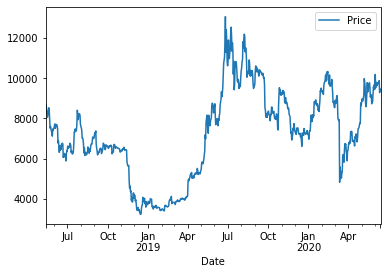

In [24]:
bitcoin_small.plot("Date", "Price")
# About the dataframe : We can see that we have data points going back 2 years (2018-2020), that associates any date with the corresponsing closing bitcoin price
# We can observe that the data has a high variance and that the variations of the data resemble that of randomly created data
# From this information, we can already guess that the data will be tough to forecast, and that getting a prediction with perfect variance and precision will be impossible

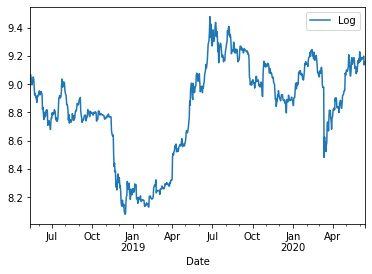

In [25]:
#Plotting the transformed data
bitcoin_small.plot("Date", "Log")

# **Step 2: Model preparation**

Finding out the parameters (p,d,q) to use in the ARIMA model.

The model requires 3 inputs : 
- parameter p : number of previous data points to use in the forecast
- parameter d : number of differentiations required to make the data stationary
- parameter q : number of previous errors to use in the forecast

**Stationarizing the data**

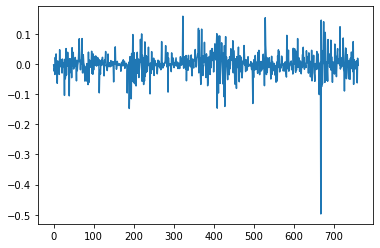

In [26]:
# In order for the ARIMA model to work, the data must be stationarized : it should be centered, with constant variance
# The diff function, by computing the difference in daily prices, helps us create a differenciated and stationary dataset for our transformed data - This will be the data used in our forecasting model
diff1=np.diff(bitcoin_small["Log"],1)
plt.plot(diff1)

**Testing for stationarity**

We have now differentiated the data once. This may not be sufficient for the data to be stationary.

We are thus testing for stationarity, to check whether a second differentiation is required.

We will an AD Fuller test, on the undifferentiated data first and then on the differentiated data.

In [27]:
# AD Fuller test on undifferentiated data
# The AD Fuller test is the most common stationarity test. It is a statistical test, displaying  the t-test value and confidence interval thresholds.
# We can thus check for stationarity by comparing the first value displayed (t-test) to the confidence intervals displayed for 1%, 10% and 5%
adfuller(bitcoin_small["Log"])
#Here, we can observe that, as previously thought, the data was not stationary before the first differentiation.

(-1.5224291797383027,
 0.5223882123621906,
 2,
 760,
 {'1%': -3.4389835846902788,
  '10%': -2.5687990737534627,
  '5%': -2.8653504478604757},
 -2661.488481961136)

In [28]:
#AD Fuller test on differentiated data
adfuller(diff1)
#Here, t t-test value is lower than the confidence interval thresholds.
# We can thus conclude that the data is stationary --> 1 differentiation seems to be sufficient
# This gives us the first parameter to use in the model : d = 1

(-18.932950702186346,
 0.0,
 1,
 760,
 {'1%': -3.4389835846902788,
  '10%': -2.5687990737534627,
  '5%': -2.8653504478604757},
 -2656.8849892736707)

**Finding the p and q parameters: ACF and PACF**

These functions (Auto-correlation function and Partial auto-correlation function) help us identify the Q (ACF) and P (PACF) parameters to use in the model.

- The ACF shows the relationship between the predicted data point and previous data points.

- The PACF does the same thing, only it neutralizes the relationship between the previous data points themselves.

*How to read the graphs:* 
For an x number on the x-axis, the graphs display the correlation between the data point we want to predict and the data point x lags before.

The points that we are interested in are those outsider of the blue area, meaning those that have a significative correlation (larger than 0.1 absolute value)

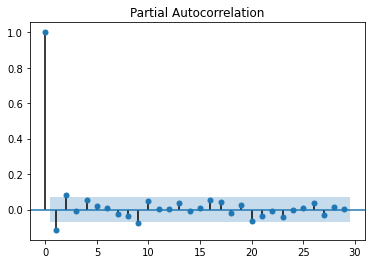

In [29]:
# Finding the Q parameter
x1 = plot_pacf(diff1)

#Here, the data points that seem interesting are : 0,1, 2, 9, 20

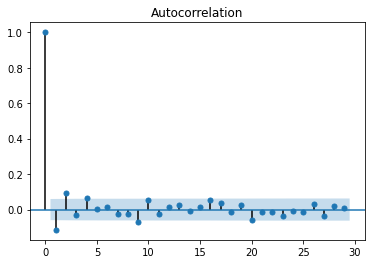

In [30]:
# Finding the P parameter
x2 = plot_acf(diff1, alpha = 0.1)

#Here, the data points that seem interesting are : 0,1, 2, 9, 10, 16, 20

In [13]:
# Creating a function to automatically test for (p,q) couples quality, to determine which parameters will yield the best results
# We tested a grid of parameters and tried to minimize the aic (a prediction quality criterion - prediction optimized at the smallest aic value)
# For each couple, we fitted the model and computed the AIC.
#nous avons tenté cette méthode d'optimisation pour déterminer les bons paramètres (fonction d'optimisation des paramètres avrc un bic), mais qnous nous sommes rendus compte que les meilleures prédictions étaient données par des paramètres assez hauts et que le temps pour fitter un modèle avec des paramètres hauts était de plusieurs minutes, donc que ce genre de fonction d'optimisation allait prendre des heures pour trouver le meilleur paramètre. Nous avons alors tenté les différentes combinaisons de paramètres à la main, afin de trouver celle qui correspondait le mieux au modèle
ACF = [0,1, 2, 9, 20]
PACF = [0,1, 2, 9, 10, 16, 20]

def bestParameter(x):
  p=0
  q=0
  min = 1000000000
  for i in ACF:
    for j in PACF:
      print (i,j)
      try:
        model = SARIMAX(x,order = (j, 1, i))
        model_fit = model.fit(disp = 0)
        if model_fit.aic < min :
          min = model_fit.aic
          print (model_fit.aic)
          p = j
          q = i
      except:
        pass
  return (p,1,q)
  #printing the best parameters for a training portion of the df : the 740 first data points
print(bestParameter(bitcoin_small["Log"][0:740]))


0 0
-2603.6846704441023
0 1
-2610.5843089399477
0 2


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


-2614.0244781893
0 9
0 10
0 16
0 20
1 0
1 1
-2614.5763247152363
1 2
1 9


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1 10
1 16
1 20


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2 0
2 1
2 2
2 9


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2 10
2 16


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2 20


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


9 0
9 1


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


9 2


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


9 9


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


9 10


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


9 16


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


9 20


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


20 0
20 1


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


20 2


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


20 9


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


20 10


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


20 16


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


20 20


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(1, 1, 1)


# **Step 3: Forecasting the data**
Fitting and applying the model

**Fitting the model**

In [31]:
#Fitting the model on a training dataset : the first 740 data points, using the chosen (p,q,m) parameters
# When the model is fitted with the parameters chosen by the tests (p=1, q=1), the prediction line is flat.
# This seems normal, given that this data is extremely hard to predict. 
# In this case, forecasting for the short term variations seems very complex, but the model seems to be able to forecast long-term trends
# We thus realized that the most accurate predictions occur for high model parameters
# So after trying different parameters through trial and error, we found that the most accurate prediction was for p=50 and q=50 (the d=1 does not change)
model = SARIMAX(bitcoin_small["Log"][0:740],order = (50,1,50))
model = model.fit()

#explication pour grands paramètres = cours assez peu explicable à très court terme sans variable explicative, donc il faut regarder des données à long terme pour avoir des données vraisemblables

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:1960: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


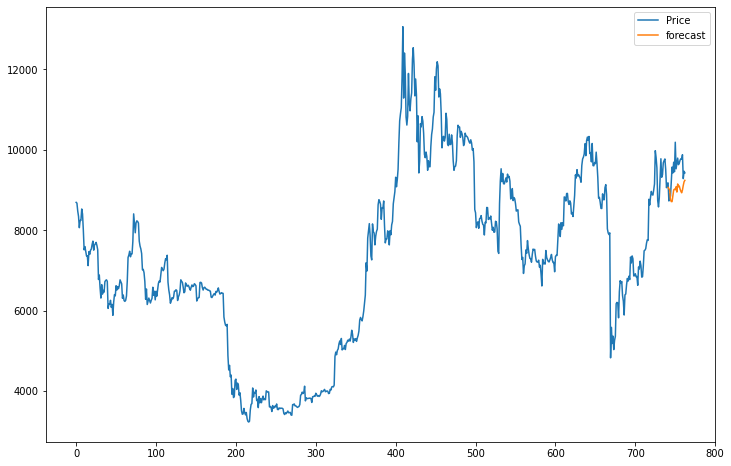

In [35]:
# Use the model to predict the remaining values of the model: values 741 to 762 
bitcoin_small["forecast_log"] = model.predict(start = 741, end= 762, dynamic= True) 

# Converting the forecasted values back to bitcoin prices by applying the exp function
bitcoin_small["forecast"] = bitcoin_small["forecast_log"].apply(np.exp) 

#plotting the forecast
bitcoin_small[['Price', 'forecast']].plot(figsize=(12, 8))
plt.show()

#prédiction pas super accurate mais sait prédire les mouvements globaux (anticipe une chute après une forte hausse par ex)

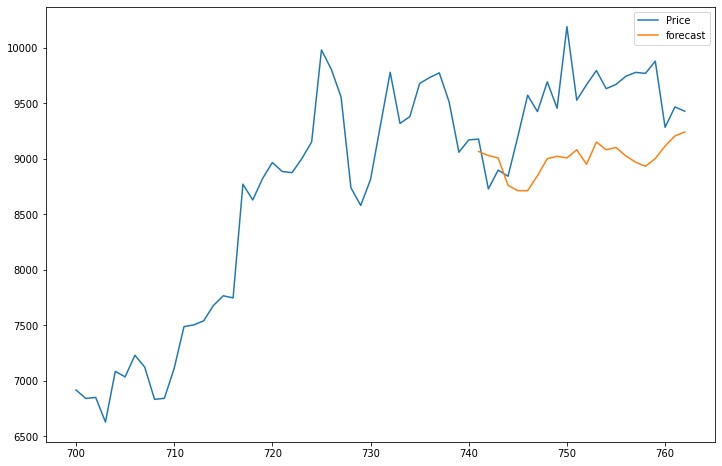

In [36]:
# Here is the prediction zoomed in

bitcoin_small[['Price', 'forecast']][700:].plot(figsize=(12, 8))
plt.show()